In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.optimize import fsolve
import time
import matplotlib.pyplot as plt
from xgboost import plot_importance, XGBClassifier
from scipy.stats.distributions import chi2
from mlxtend.evaluate import bias_variance_decomp

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/scoring_model_data.csv')

In [ ]:
features = [
    'max_util', 
    'avg_util',
    'credits_2y',
    'credits_4y',
    'bad_history_credits_flg',
    'other_util', 'avg_term',
    'min_term',
    'avg_limit_mortgage',
    'min_limit_mfo', 
    'close_balance_amt',
    'soc_dem_score',
    'max_delq_cnt',
    'avg_active_time',
    'last_credit_time_years'
]

In [ ]:
def test_val_split(df, val_size=0.2, test_size=0.2):
    
    """
        Функция для разбиения выборки на три части по времени (hold-out подход)
        
        Parameters
        ----------
        df : DataFrame
            датафрейм с наблюдениями и целевой переменной
        val_size : str
            размер валидационной выборки
        test_size : str
            размер тестовой выборки

        Returns
        ---
        df : pandas.DataFrame
           исходный датафрейм с новой колонкой sample_part принимающей три значения:
           'train', 'val', 'test'

    """
    
    X_train, X_test, y_train, y_test = train_test_split(
        df[features], df['d4p12'], test_size=val_size+test_size, shuffle=False)
    df.assign(sample_part='')
    df.loc[X_test.index, 'sample_part'] = 'test'
    X_val, X_test, y_val, y_test = train_test_split(
        df[features][df['sample_part'] == 'test'], df['d4p12'][df['sample_part'] == 'test'],\
        test_size=test_size / (test_size + val_size), shuffle=False)
    df.loc[X_val.index, 'sample_part'] = 'validation'
    df.loc[X_train.index, 'sample_part'] = 'train'
    return df

In [ ]:
df = df.sort_values(by=['user_id'])
df = test_val_split(df)

# Препроцессинг данных и обработка пропусков

#### Избавимся от дубликатов в датасете.

In [ ]:
df = df.drop_duplicates(keep='first')

In [ ]:
df.head()

,user_id,d4p12,month_dt,max_util,avg_util,credits_2y,credits_4y,bad_history_credits_flg,other_util,avg_term,min_term,avg_limit_mortgage,min_limit_mfo,close_balance_amt,soc_dem_score,max_delq_cnt,avg_active_time,last_credit_time_years,sample_part
0,0.0,0.0,2019-01-01,0.991360,0.991360,0.00000,1.0,1.0,1.000000,29.000000,29.0,-1.0,-1.0,51864.00,-5.898175,0.0,NaN,0.0,train
222275,0.0,-20.0,1349455.0,-1.000000,612562.000000,-6.70908,0.0,127.0,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
1,1.0,0.0,2019-01-01,0.928482,0.271159,0.00000,0.0,1.0,0.296724,86.928571,1.0,-1.0,-1.0,1424742.89,-7.067999,0.0,49.0,1.0,train
2,2.0,0.0,2019-01-01,1.418333,0.079951,0.00000,0.0,1.0,0.219805,-0.065789,-24.0,-1.0,20000.0,254827.00,-7.295431,0.0,47.0,16.0,train
3,3.0,0.0,2019-01-01,1.042425,0.230797,1.00000,1.0,1.0,0.284345,116.615385,-5.0,-1.0,-1.0,138969.00,-5.073265,0.0,23.0,3.0,train


#### Заметим, что для клиента с id = 0 присутствуют 2 наблюдения, в одном из которых большая часть значений признаков не определена, а другие явно не корректны, что делает это наблюдение бесполезным, избавимся от него.

In [ ]:
df = df.drop([222275])

#### Реализуем функцию, которая вычисляем, при каком значении признака WoE для него = 0.

In [ ]:
def woe_equals_0(feature, target):
    """ 
    Вычисляет значение, при котором WoE = 0

    feature - признак, для которого считаем WoE
    target - метки класса (0 / 1)
    
    """
    df_woe = pd.DataFrame()
    df_woe['feature'] = feature
    df_woe['target'] = target
    df_woe = df_woe.dropna()

    all_0, all_1 = list(df_woe['target'].value_counts())
    target_log = np.log(all_1 / all_0)

    model = LogisticRegression(fit_intercept=True)
    model.fit((np.array(df_woe['feature'])).reshape(-1, 1), df_woe['target'].values.ravel())
    a_0 = model.intercept_[0]
    a_1 = model.coef_[0]

    woe = lambda x : a_0 + a_1 * x - target_log
    
    #берем в качестве начального приближения медиану признака
    return fsolve(woe, feature.median())[0]

#### Посмотрим, для каких признаков присутствуют пропуски.

In [ ]:
df.isnull().sum()

user_id                        0
d4p12                          0
month_dt                       0
max_util                       0
avg_util                       0
credits_2y                     0
credits_4y                     0
bad_history_credits_flg        0
other_util                     0
avg_term                      38
min_term                      38
avg_limit_mortgage             0
min_limit_mfo                  0
close_balance_amt              0
soc_dem_score                  0
max_delq_cnt                   0
avg_active_time            13710
last_credit_time_years         0
sample_part                    0
dtype: int64

Пропуски есть для среднего срока по кредиту, минимального срока по кредиту и среднего оставшегося времени по открытам кредитам.

Правило заполнения пропусков будем искать на обучающей выборке, попробуем несколько подходов: 

*   замена на нулевое значение 
*   замена на среднее
*   замена на медиану
*   замена на значение, при котором WoE признака = 0
*   замена на моду

Так как далее мы будем отбирать признаки по ROC-AUC, будем брать тот способ, при котором метрика будет наибольшей.






Реализуем функцию, которая будет перебирать подходы для заполнения.

In [ ]:
def best_fill_search(target, feature):
  best_fill =''
  best_roc_auc=0

  """
  Parameters
  ----------

  feature : pandas.Series
            признак из обучающей выборки
  
  target : pandas.Series
           целевая переменная 

            
  Returns
  -------
  best_fill : str
              лучший подход для заполнения

    """

  zero_roc_auc = roc_auc_score(target, feature.fillna(0))
  print(f"ROC-AUC при заполнении 0 : {format(zero_roc_auc, '.6f')}")

  if zero_roc_auc > best_roc_auc:
    best_roc_auc = zero_roc_auc
    best_fill = '0'

  mean_roc_auc = roc_auc_score(target, feature.fillna(feature.mean()))
  print(f"ROC-AUC при заполнении средним : {format(mean_roc_auc, '.6f')}")

  if mean_roc_auc > best_roc_auc:
    best_roc_auc = mean_roc_auc
    best_fill = 'среднее'
  
  median_roc_auc = roc_auc_score(target, feature.fillna(feature.median()))
  print(f"ROC-AUC при заполнении медианой : {format(median_roc_auc, '.6f')}")

  if median_roc_auc > best_roc_auc:
    best_roc_auc = median_roc_auc
    best_fill = 'медиана'

  woe_roc_auc = roc_auc_score(target, feature.fillna(woe_equals_0(feature, target)))
  print(f"ROC-AUC при заполнении x : WoE(x) = 0 : {format(woe_roc_auc, '.6f')}")

  if woe_roc_auc > best_roc_auc:
    best_roc_auc = woe_roc_auc
    best_fill = 'Woe'

  mode_roc_auc = roc_auc_score(target, feature.fillna(feature.mode()[0]))
  print(f"ROC-AUC при заполнении модой : {format(mode_roc_auc, '.6f')}")

  if mode_roc_auc > best_roc_auc:
    best_roc_auc = median_roc_auc
    best_fill = 'мода'

  return best_fill


avg_term

In [ ]:
target = df['d4p12'][df['sample_part'] == 'train']
feature = df['avg_term'][df['sample_part'] == 'train']

In [ ]:
best_fill_search(target, feature)

ROC-AUC при заполнении 0 : 0.523069
ROC-AUC при заполнении средним : 0.522986
ROC-AUC при заполнении медианой : 0.523009
ROC-AUC при заполнении x : WoE(x) = 0 : 0.522985
ROC-AUC при заполнении модой : 0.523068


'0'

In [ ]:
df['avg_term'][df['avg_term'] < 0].count()

14391

В датасете есть $\approx$ 14 тысяч наблюдений, для которых средний срок по кредиту отрицательный, что контринтуитивно и, возможно, является некоректной информацией. Попробуем воспринимать такие наблюдения как пропуски и посчитать ROC-AUC при их замене.

In [ ]:
best_fill_search(target, feature.apply(lambda x : np.nan if x < 0 else x))

ROC-AUC при заполнении 0 : 0.523133
ROC-AUC при заполнении средним : 0.519405
ROC-AUC при заполнении медианой : 0.520486
ROC-AUC при заполнении x : WoE(x) = 0 : 0.519185
ROC-AUC при заполнении модой : 0.523236


'мода'

Лучшая метрика получилась, когда мы заполняем пропуски и отрицательные значения модой, выбираем данный подход.

In [ ]:
df['avg_term'] = df['avg_term'].apply(lambda x : np.nan if x < 0 else x)
df['avg_term'] = df['avg_term'].fillna(feature.mode()[0])

min_term

In [ ]:
feature = df['min_term'][df['sample_part'] == 'train']

In [ ]:
best_fill_search(target, feature)

ROC-AUC при заполнении 0 : 0.505041
ROC-AUC при заполнении средним : 0.505064
ROC-AUC при заполнении медианой : 0.505056
ROC-AUC при заполнении x : WoE(x) = 0 : 0.505064
ROC-AUC при заполнении модой : 0.505021


'среднее'

In [ ]:
df['min_term'][df['min_term'] < 0].count()

124012

Больше половины наблюдений отрицательны, что также не характерно для этого признака, попробуем считать их пропусками.

In [ ]:
best_fill_search(target, feature.apply(lambda x : np.nan if x < 0 else x))

ROC-AUC при заполнении 0 : 0.503034
ROC-AUC при заполнении средним : 0.502415
ROC-AUC при заполнении медианой : 0.500884
ROC-AUC при заполнении x : WoE(x) = 0 : 0.502156
ROC-AUC при заполнении модой : 0.500884


'0'

От замены отрицательных наблюдений на пропуски улучшений не получили, заполняем значением признака средним.

In [ ]:
df['min_term'] = df['min_term'].fillna(df['min_term'].mean())

avg_active_time

In [ ]:
feature = df['avg_active_time'][df['sample_part'] == 'train']

In [ ]:
best_fill_search(target, feature)

ROC-AUC при заполнении 0 : 0.525928
ROC-AUC при заполнении средним : 0.526093
ROC-AUC при заполнении медианой : 0.529598
ROC-AUC при заполнении x : WoE(x) = 0 : 0.526223
ROC-AUC при заполнении модой : 0.525909


'медиана'

In [ ]:
df['avg_active_time'][df['avg_active_time'] < 0].count()

28746

Аналогичная ситуация с отрицательными значениями, что и для двух признаков выше.

In [ ]:
best_fill_search(target, feature.apply(lambda x : np.nan if x < 0 else x))

ROC-AUC при заполнении 0 : 0.525469
ROC-AUC при заполнении средним : 0.506224
ROC-AUC при заполнении медианой : 0.523756
ROC-AUC при заполнении x : WoE(x) = 0 : 0.506441
ROC-AUC при заполнении модой : 0.524858


'0'

От замены отрицательных наблюдений на пропуски не получили превосходящего значения метрики, заполняем медианой

In [ ]:
df['avg_active_time'] = df['avg_active_time'].fillna(df['avg_active_time'].median())

#### Изучим также признаки, в которых номинально нет пропусков. Посмотрим, есть ли среди них те, что принимают отрицательные значения.

In [ ]:
for feature in features:
  print(f"признак :  {feature}, количество элементов < 0 : {df[feature][df[feature] < 0].count()}")

признак :  max_util, количество элементов < 0 : 0
признак :  avg_util, количество элементов < 0 : 0
признак :  credits_2y, количество элементов < 0 : 0
признак :  credits_4y, количество элементов < 0 : 0
признак :  bad_history_credits_flg, количество элементов < 0 : 0
признак :  other_util, количество элементов < 0 : 0
признак :  avg_term, количество элементов < 0 : 0
признак :  min_term, количество элементов < 0 : 124050
признак :  avg_limit_mortgage, количество элементов < 0 : 178245
признак :  min_limit_mfo, количество элементов < 0 : 192708
признак :  close_balance_amt, количество элементов < 0 : 0
признак :  soc_dem_score, количество элементов < 0 : 222230
признак :  max_delq_cnt, количество элементов < 0 : 0
признак :  avg_active_time, количество элементов < 0 : 28746
признак :  last_credit_time_years, количество элементов < 0 : 0


Замечаем отрицательные наблюдения дополнительно для avg_limit_mortgage, min_limit_mfo, soc_dem_score. 

In [ ]:
df['avg_limit_mortgage'].value_counts()

-1.000000e+00    178245
 1.000000e+06       784
 2.000000e+06       702
 1.500000e+06       671
 3.000000e+06       492
                  ...  
 1.048078e+06         1
 1.891650e+06         1
 2.449937e+06         1
 2.067700e+06         1
 3.598000e+06         1
Name: avg_limit_mortgage, Length: 16380, dtype: int64

In [ ]:
df['min_limit_mfo'].value_counts()

-1.0        192708
 30000.0      1194
 10000.0      1046
 15000.0      1023
 20000.0       828
             ...  
 3336.0          1
 61780.0         1
 13250.0         1
 64620.0         1
 51953.0         1
Name: min_limit_mfo, Length: 11851, dtype: int64

Заметим, что для подавляющего большинства наблюдений значения этих двух признаков = -1, мне кажется, это можно интерпретировать двумя способами: либо для данных клиентов нет информации о том, пытались ли они брать ипотеку или обращаться в микрофинансовые организации, либо они не соответствуют определенным критериям, чтобы им одобрили хотя бы какую-то ипотеку или минимальный микрозайм. Я всё-таки склоняюсь к 1 варианту, ибо данное значение стоит у подавляющего большинства клиентов ($\approx$ 80 % для avg_limit_mortgage и $\approx$ 87 % для min_limit_mfo), вряд ли все они получили отказ. 

Попробуем посчитать ROC-AUC как есть и в предположении, что отрицательные значения - пропуски.

avg_limit_mortgage

In [ ]:
feature = df['avg_limit_mortgage'][df['sample_part'] == 'train']
roc_auc_score(target, feature)

0.461783332501106

In [ ]:
best_fill_search(target, feature.apply(lambda x : np.nan if x < 0 else x))

ROC-AUC при заполнении 0 : 0.461783
ROC-AUC при заполнении средним : 0.499269
ROC-AUC при заполнении медианой : 0.488847
ROC-AUC при заполнении x : WoE(x) = 0 : 0.489589
ROC-AUC при заполнении модой : 0.466790


'среднее'

Из значений метрик выше понимаем, что не нужно заменять отрицательные значения на пропуски, но стоит домножить признак на -1, чтобы инвертировать ROC-AUC.

In [ ]:
df['avg_limit_mortgage'] = -df['avg_limit_mortgage']


min_limit_mfo


In [ ]:
feature = df['min_limit_mfo'][df['sample_part'] == 'train']
roc_auc_score(target, feature)

0.5466459907476451

In [ ]:
best_fill_search(target, feature.apply(lambda x : np.nan if x < 0 else x))

ROC-AUC при заполнении 0 : 0.546646
ROC-AUC при заполнении средним : 0.471289
ROC-AUC при заполнении медианой : 0.495306
ROC-AUC при заполнении x : WoE(x) = 0 : 0.467669
ROC-AUC при заполнении модой : 0.482423


'0'

Заменять на отрицательные значения на пропуски также не стоит.

Что касается soc_dem_score, неизвестно по какой шкале он рассчитывается, возможно в ней есть отрицательные значения + скор < 0 для почти всех клиентов, так что я решил оставить этот признак без изменений.

#### Отберем признаки по ROC-AUC

Отберем признаки, для которых ROC-AUC > 0.525

In [ ]:
best_features_and_auc = {}

for feature in features:
  roc_auc = roc_auc_score(df['d4p12'], df[feature])
  if max(roc_auc, 1-roc_auc) > 0.525:
    best_features_and_auc[feature] = roc_auc

filtered_features_and_auc = pd.Series(best_features_and_auc).sort_values(ascending=False)

print(filtered_features_and_auc)

filtered_features = list(filtered_features_and_auc.index)

max_util                  0.617293
soc_dem_score             0.593044
avg_util                  0.591216
other_util                0.589252
last_credit_time_years    0.584362
credits_4y                0.573496
credits_2y                0.562459
avg_limit_mortgage        0.543306
min_limit_mfo             0.542078
close_balance_amt         0.457678
dtype: float64


In [ ]:
df['close_balance_amt'] = -df['close_balance_amt']

Также мне показалось разумным добавить к признакам avg_active_time, который показал неплохой ROC-AUC ($\approx$ 0.53) на обучающей выборке.

In [ ]:
filtered_features.append('avg_active_time')

### Проведем EDA для max_util, soc_dem_score, avg_util

In [ ]:
top_3_df = ['max_util', 'avg_util', 'soc_dem_score']

Посмотрим, как сильно коррелируют эти 3 признака друг с другом

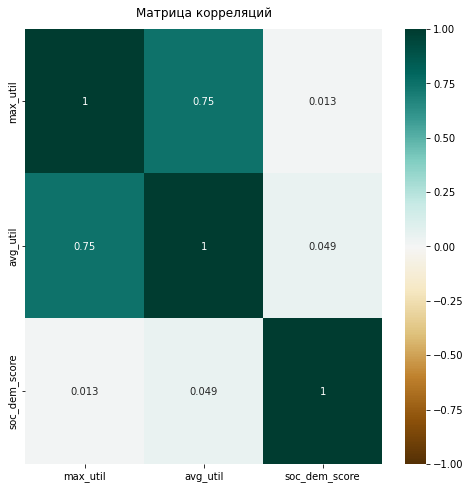

In [ ]:
plt.figure(figsize=(8, 8))
heatmap = sns.heatmap(df[top_3_df].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Матрица корреляций', fontdict={'fontsize':12}, pad=12);

Отметим сильную корреляцию между максимальной утилизацией по КК и средней утилизацией по КК, что неудивительно, ведь они описывают одну и ту же величину (отношение задолженности к лимиту), мне кажется, если клиент, как правило, не использует существенную часть своего лимита, то и не стоит ожидать, что максимальный показатель задолженности будет составлять большую часть доступного предела, ну и наоборот, если расходы человека сильно опираются на кредитный ресурс, то и максимум будет выше.

Также мне показалось важным посмотреть, какова доля клиентов, для которых долг превысил допустимый лимит касательно max_util и avg_util. Понятно, что если для человека средняя утилизация по КК > 1, то и максимальная утилизация по КК будет > 1, а наоборот может быть верно не всегда, например, когда среди всех наблюдений для конкретного клиента есть лишь единичные случаи превышения лимита. Посмотрим, есть ли у нас такие ситуации.

In [ ]:
print(f"Количество превышений относительно максимальной утилизации по КК : {format(df['max_util'][df['max_util'] > 1].count()/df['max_util'].count(), '.4f')}")

print(f"Количество превышений относительно средней утилизации по КК : {format(df['avg_util'][df['avg_util'] > 1].count()/df['avg_util'].count(), '.6f')}")

Количество превышений относительно максимальной утилизации по КК : 0.1741
Количество превышений относительно средней утилизации по КК : 0.009961


Наше предположение подтвердилось, в нашем датасете $\approx$ 17 % клиентов, для которых хотя бы раз задолженность превышала лимит, и всего $\approx$ 1 % тех, для кого это происходило систематически.

Но здесь мы не учитываем возможную некорректность данных, поэтому выставим порог = 5, свыше которого мы будем считать данные неправдоподобными, иными словами будем считать аномалиями все наблюдения, для которых лимит был превышен более, чем в 5 раз.

In [ ]:
print(f"Доля превышений относительно максимальной утилизации по КК : {format((df['max_util'][df['max_util'] > 1].count() - df['max_util'][df['max_util'] >= 5].count()) /df['max_util'].count(), '.4f')} при пороге = 5")

print(f"Доля превышений относительно средней утилизации по КК : {format((df['avg_util'][df['avg_util'] > 1].count() - df['max_util'][df['max_util'] >= 5].count()) / df['avg_util'].count(), '.4f')} при пороге = 5")

Доля превышений относительно максимальной утилизации по КК : 0.1679 при пороге = 5
Доля превышений относительно средней утилизации по КК : 0.0038 при пороге = 5


Отметим, что для max_util доля аномалий незначительна, а для avg_util она превышает половину.

На самом деле, подавляющее большинство клиентов не превышало лимит более, чем в 2 раза исходя из порога = 2

In [ ]:
print(f"Доля превышений относительно максимальной утилизации по КК : {format((df['max_util'][df['max_util'] > 1].count() - df['max_util'][df['max_util'] >= 2].count()) /df['max_util'].count(), '.4f')} при пороге = 2")


Доля превышений относительно максимальной утилизации по КК : 0.1635 при пороге = 2


Для дальнейшего анализа обработаем выбросы и возможные аномалии. Учитывая привёдённую выше информацию, для avg_util достаточно взять 99 персентиль, а max_util ограничить сверху двойкой.

In [ ]:
df['avg_util'] = df['avg_util'].clip(upper=np.percentile(df['avg_util'], 99))
df['max_util'] = df['max_util'].clip(upper=2)

Построим ящики с усами

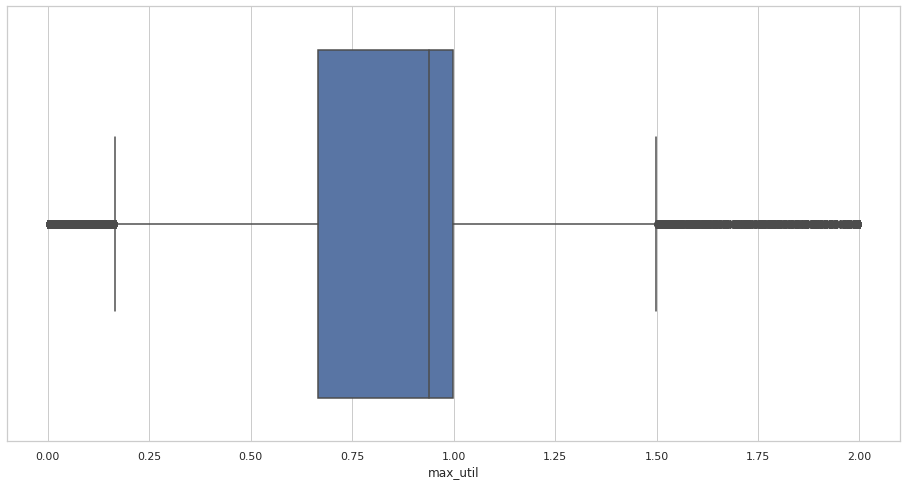

In [ ]:
plt.figure(figsize=(16, 8))
sns.set_theme(style='whitegrid');
sns.boxplot(x=df['max_util']);

Можно сделать следующие выводы:

*   практически половина клиентов расходовали большую часть лимита (от 75 % до 90 %) 

*   незначительна доля тех, у кого задолженность превысила допустимый предел более, чем в 1.5 раза

*   есть клиенты, которые несущественно потратили предоставленный лимит

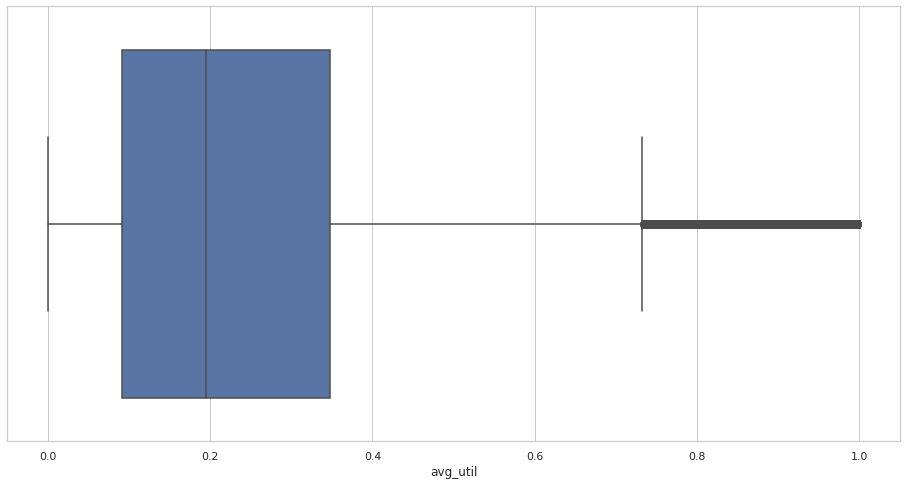

In [ ]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=df['avg_util']);

Здесь можно высказать следующие мысли:

*   подавляюшая часть клиентов в среднем не превышали даже 80 % лимита
*   половина людей расходовала, как правило, от 10 % до 35 % предоставленного предела
*   менее 25 % клиентов тратили в среднем хотя бы 10 процентов лимита 


Построим график зависимостей.

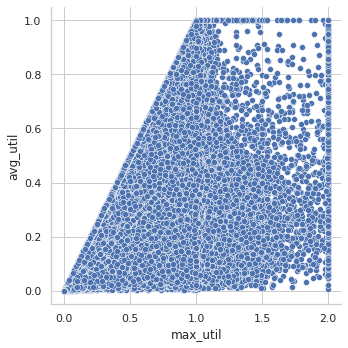

In [ ]:
sns.relplot(x='max_util', y='avg_util', data=df);

Из этого графика можно сделать интересный вывод, что в датасете присутствуют наблюдения, для которых максимальная утилизация по КК находится в районе 1-2 и в то же самое время средняя утилизация по КК располагается в окрестности нуля, подтверждая тот факт, что есть клиенты, которые практически не пользовались лимитом, а в какой-то момент разово расходовали большую его часть, возможно, это связано с большими покупками. 

Дополним визуализации графиками распределений.

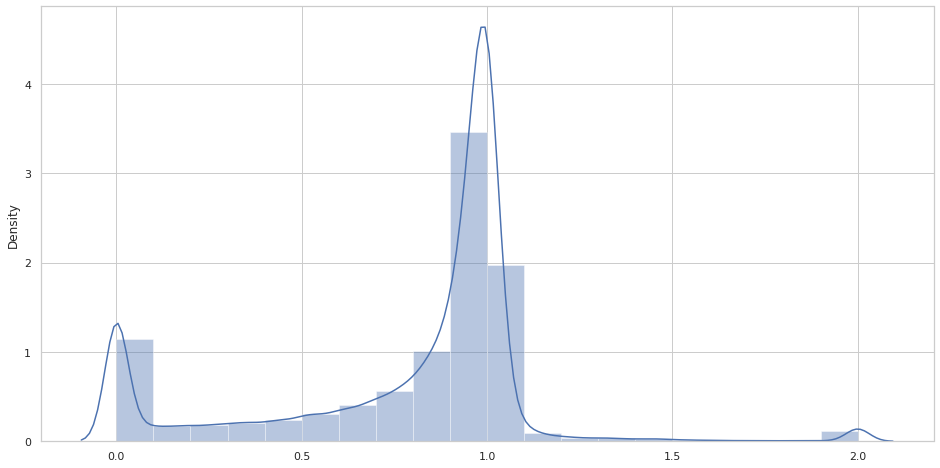

In [ ]:
plt.figure(figsize=(16, 8))
sns.distplot(x=df['max_util'], bins=20);

Здесь отчётливее виден скачок, сигнализирующий, что довольно много клиентов вообще не пользовались предоставленным лимитом.

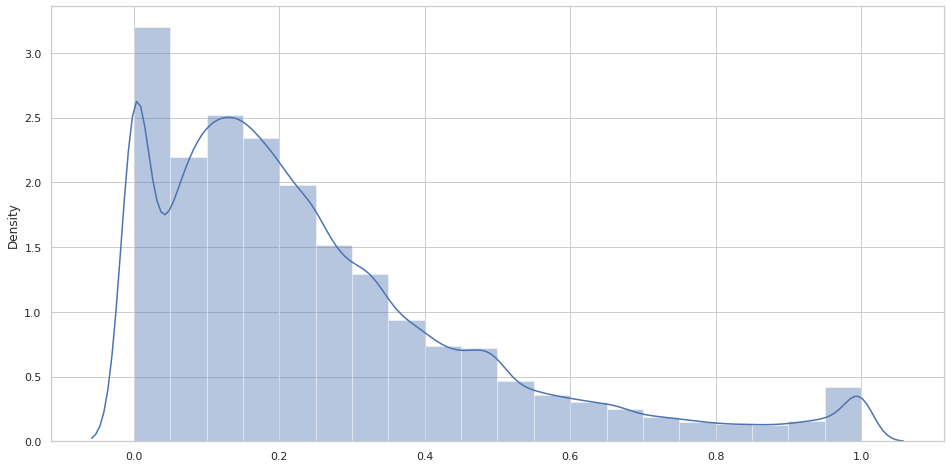

In [ ]:
plt.figure(figsize=(16, 8))
sns.distplot(x=df['avg_util'], bins=20);

Опять таки видим сильный скачок в нуле, если не принимать его во внимание, можно судить о том, что график для avg_util напоминает гамма-распределение, чаще всего клиенты в среднем тратят 10-20 % лимита, а далее расход идёт на убыль.

soc_dem_score 

Теперь исследуем скоринговый балл, основанный на соц-дем показателях. Для начала посмотрим на ящик с усами.

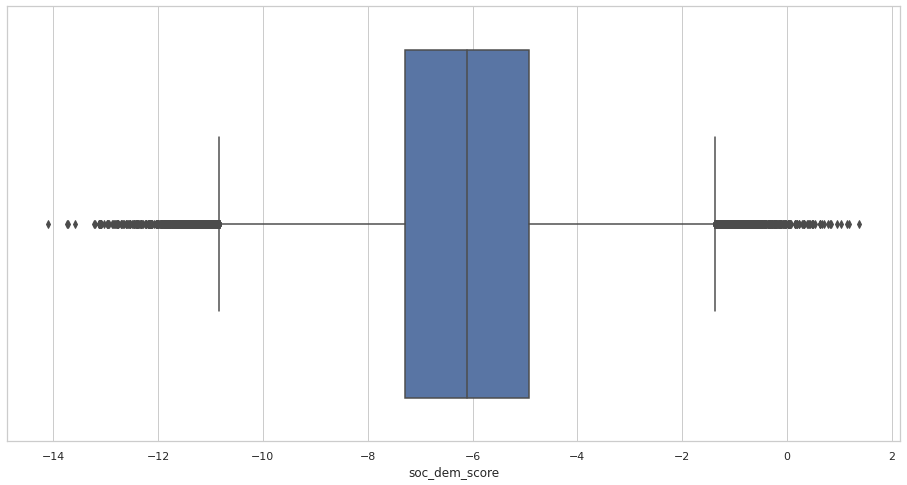

In [ ]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=df['soc_dem_score']);

Довольно сложно интерпретировать отрицательный скор, так как непонятно, что характеризует клиента с лучшей стороны - когда он больше или меньше. 
Из ящика наблюдаем:

* больше половины клиентов имеют скор от -8 до -4
* у довольно малого количества людей скор < -10 или > -2

Выбросы несущественно отличаются от основной массы значений, поэтому не будем от них избавляться.

Оценим распределение признака.

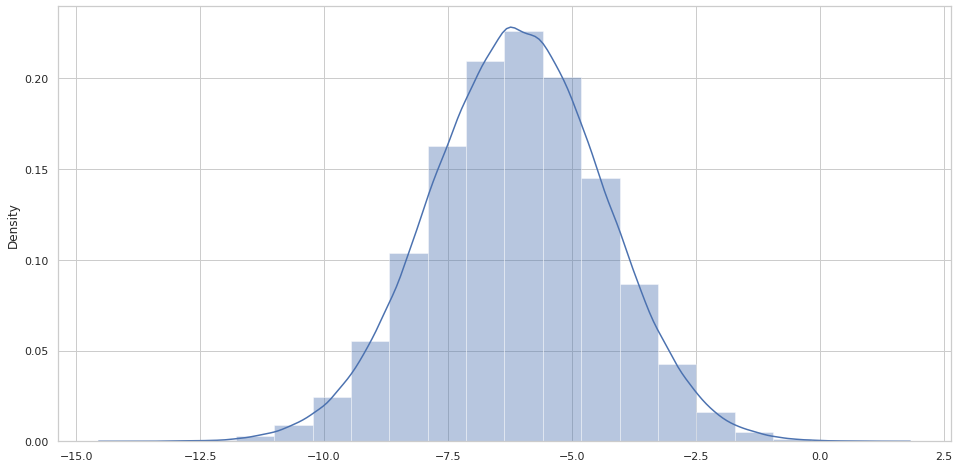

In [ ]:
plt.figure(figsize=(16, 8))
sns.distplot(x=df['soc_dem_score'], bins=20);

Можно судить о нормальном распределении показателей скора.

Посмотрим на зависимости скора от утилизаций.

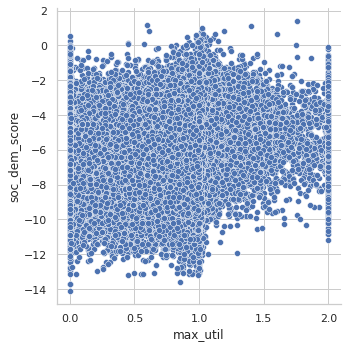

In [ ]:
sns.relplot(x='max_util', y='soc_dem_score', data=df);

Отметим резкий переход для клиентов, которые хотя бы раз превышали допустимый предел, для них скор сильнее концентрируется в районе -6, так что, возможно, есть определённая связь между возрастом, полом, количеством детей, прочими соц-дем показателями и гототвностью тратить больше лимита.

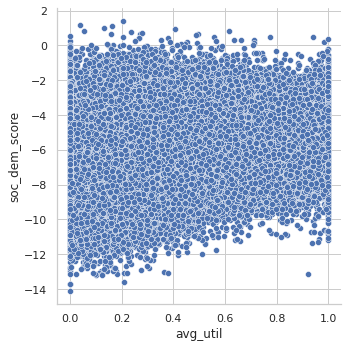

In [ ]:
sns.relplot(x='avg_util', y='soc_dem_score', data=df);

Здесь также есть зависимость с графика выше, но она еле видна.

Посмотрим на ROC-AUC преобразованных признаков.

In [ ]:
print(f"ROC-AUC для преобразованной средней утилизации по КК {format(roc_auc_score(df['d4p12'], df['avg_util']), '.6f')}")

print(f"ROC-AUC для преобразованной максимальной утилизации по КК {format(roc_auc_score(df['d4p12'], df['max_util']), '.6f')}")

ROC-AUC для преобразованной средней утилизации по КК 0.591220
ROC-AUC для преобразованной максимальной утилизации по КК 0.617301


## Теперь построим матрицу корреляций для всех отобранных признаков

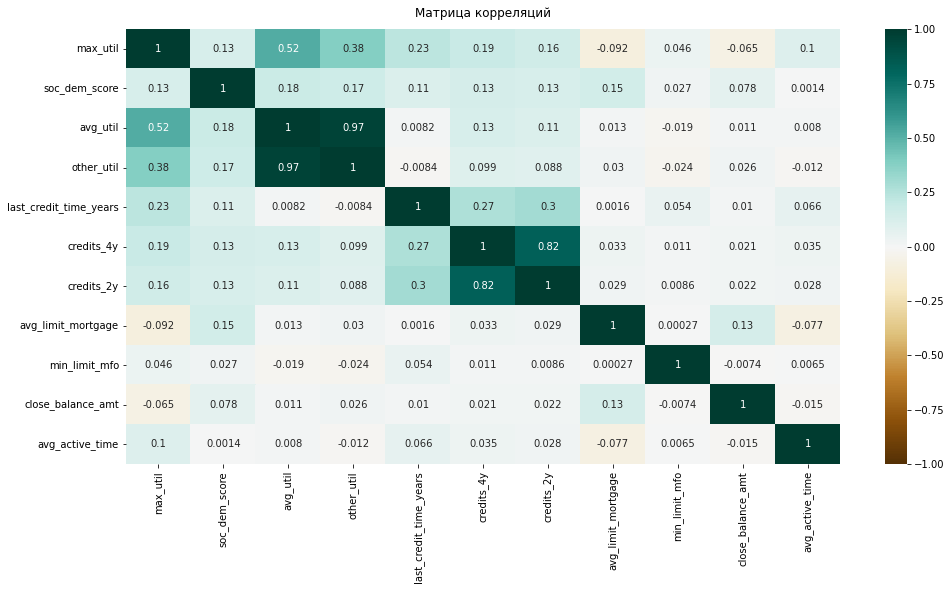

In [ ]:
plt.figure(figsize=(16, 8))
heatmap = sns.heatmap(df[filtered_features].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Матрица корреляций', fontdict={'fontsize':12}, pad=12);

Отметим 3 сильные корреляции:

*   найденная ранее между максимальной утилизацией по КК и средней утилизацией по КК
*   между отношением задолженности к сумме кредитов в других организациях и средней утилизацией по КК
*   количествами кредитов за последние 2 и 4 года соответственно

Я решил оставить max_util_trans и убрать avg_util_trans, так как максимальная утилизация - самый сильный признак по ROC-AUC + avg_util_trans почти полностью коррелирует с other_util.

Также я исключил credits_2y, так как сredits_4y охватывает больший временной диапазон, значит может быть более репрезентативен, а также, скорее всего, содержит в себе информацию из credits_2y + для этого признака ROC-AUC немного больше. 

In [ ]:
filtered_features.remove('avg_util')
filtered_features.remove('credits_2y')

## Градиентный бустинг

Реализуем grid search для градиентного бустинга.

In [ ]:
def grid_search(X_train, y_train, X_val, y_val, parameters):
  """
  Parameters
  __________

  X_train : DataFrame
            наблюдения из обучающей выборки
  y_train : Series
            значение таргета на обучающей выборке
  X_val : DataFrame
            наблюдения из валидационной выборки
  y_val : Series
            значение таргета на валидационной выборке
  parameters : Dict
            словарь списков гиперпараметров

  Returns
  _______

  best_param : Dict
            лучший набор гиперпараметров
  """

  param_list = list(ParameterGrid(parameters))

  best_param = {
     'n_estimators' : 0,
     'max_depth' : 0
      }

  best_roc_auc = 0

  for cand in param_list:
    start_time = time.time()
    model=XGBClassifier(max_depth=cand['max_depth'], n_estimators=cand['n_estimators'])
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_val)[:,1]
    valid_roc_auc = roc_auc_score(y_val, predictions)

    if valid_roc_auc > best_roc_auc:
      best_roc_auc = valid_roc_auc
      best_param['n_estimators'] = cand['n_estimators']
      best_param['max_depth']=cand['max_depth']

  
    print(f'Prediction time for {cand} = {round(time.time() - start_time, 3)} s')
    print(f'ROC-AUC for {cand} = {valid_roc_auc} s')
    print()

  return best_param

In [ ]:
cand_param = {
     'n_estimators' : [10, 25, 70, 300],
     'max_depth' : [3, 4, 5],
      }

X_filtered_train = df[filtered_features][df['sample_part'] == 'train']
y_filtered_train = df['d4p12'][df['sample_part'] == 'train']
X_filtered_val = df[filtered_features][df['sample_part'] == 'validation']
y_filtered_val = df['d4p12'][df['sample_part'] == 'validation']
X_filtered_test = df[filtered_features][df['sample_part'] == 'test']
y_filtered_test = df['d4p12'][df['sample_part'] == 'test']

grid_search(X_filtered_train, y_filtered_train, X_filtered_val, y_filtered_val, cand_param)

Prediction time for {'max_depth': 3, 'n_estimators': 10} = 2.058 s
ROC-AUC for {'max_depth': 3, 'n_estimators': 10} = 0.6303463164789881 s

Prediction time for {'max_depth': 3, 'n_estimators': 25} = 4.708 s
ROC-AUC for {'max_depth': 3, 'n_estimators': 25} = 0.6376844639892659 s

Prediction time for {'max_depth': 3, 'n_estimators': 70} = 9.027 s
ROC-AUC for {'max_depth': 3, 'n_estimators': 70} = 0.6534799892911323 s

Prediction time for {'max_depth': 3, 'n_estimators': 300} = 27.532 s
ROC-AUC for {'max_depth': 3, 'n_estimators': 300} = 0.6544460880578578 s

Prediction time for {'max_depth': 4, 'n_estimators': 10} = 1.445 s
ROC-AUC for {'max_depth': 4, 'n_estimators': 10} = 0.6361468583900578 s

Prediction time for {'max_depth': 4, 'n_estimators': 25} = 3.326 s
ROC-AUC for {'max_depth': 4, 'n_estimators': 25} = 0.6446019606785183 s

Prediction time for {'max_depth': 4, 'n_estimators': 70} = 9.339 s
ROC-AUC for {'max_depth': 4, 'n_estimators': 70} = 0.6539525336173861 s

Prediction time f

{'max_depth': 5, 'n_estimators': 70}

Лучшие параметры: глубина дерева = 5, количество оценщиков = 70



Зафитим бустинг на объединении обучающей и валидационной выборок. 

In [ ]:
model=XGBClassifier(max_depth=5, n_estimators=70)
model.fit(df[filtered_features][df['sample_part'] != 'test'], df['d4p12'][df['sample_part'] != 'test'])
predictions = model.predict_proba(df[filtered_features][df['sample_part'] == 'test'])[:,1]
print(f" ROC-AUC = {format(roc_auc_score(df['d4p12'][df['sample_part'] == 'test'], predictions), '.3f')}")

 ROC-AUC = 0.646


Модель удовлетворяет заданному порогу.

## Визуализируем 7 самых сильных признаков по gain

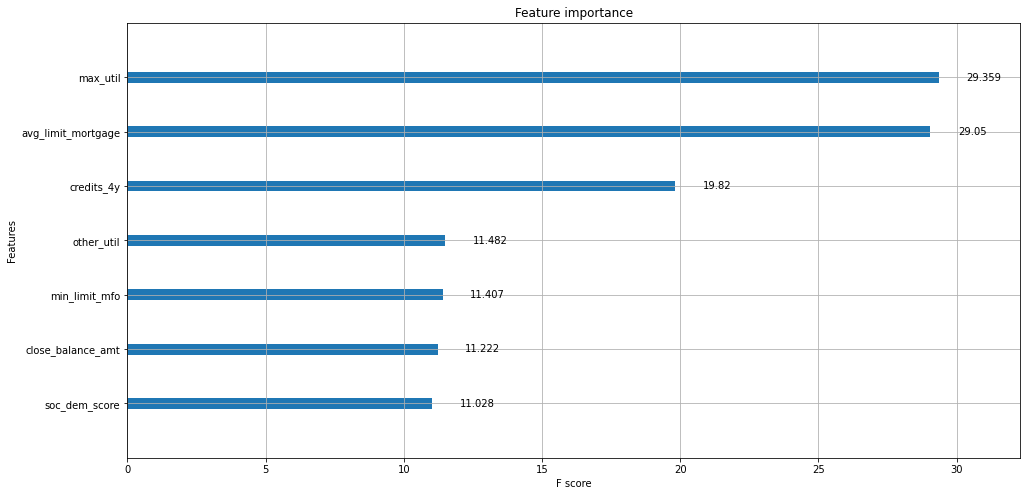

In [ ]:
booster = model.get_booster()

importance = booster.get_score(importance_type="gain")

for key in importance.keys():
    importance[key] = round(importance[key],3)

plt.rcParams["figure.figsize"] = (16,8)
plot_importance(importance, max_num_features=7, importance_type='gain', show_values=True)

Самый сильный признак по gain - максимальная утилизация по КК. Мне кажется, чем больше максимальное отношение задолженности к лимиту, тем вероятнее, что клиент выйдет в дефолт, ведь допустимый предел вычисляется исходя из различных параметров, основанных на платежеспособности человека, и если он расходует его полностью или даже сверх лимита, не ясно, как он будет возвращать деньги.

Посмотрим на долю клиентов, которые хотя бы раз превысили максимальный лимит, среди тех, с кем случился дефолт.

In [ ]:
print(format(df['d4p12'][(df['max_util'] > 1) & (df['d4p12'].eq(1))].count() / df['d4p12'][df['d4p12'].eq(1)].count() , '.2f'))

0.29


Как видим, почти каждый третий, кто превышал допустимый предел, уходил в дефолт.

Теперь посмотрим на долю людей, которые не ушли в дефолт, но расходовали больше максимального лимита.

In [ ]:
print(format(df['d4p12'][(df['max_util'] > 1) & (df['d4p12'].eq(0))].count() / df['d4p12'][df['d4p12'].eq(0)].count(), '.2f'))

0.17


Cреди людей, которые не уходили в просрочку глубины 4, процент тех, кто превышал максимальный лимит меньше, чем среди клиентов, выпавших в дефолт.

## Реализуем функцию stepwise для логистической регрессии.

In [ ]:
def likelihood_ratio_test(ll_short, ll_long):
    
    """
    вспомогательная функция
    рассчитывает значение p-value для теста отношения правдоподобия
    ll_short — логарифм правдоподобия "короткой" модели
    ll_long — логарифм правдоподобия "длинной" модели

    Returns
    -----
    p-value
    """
    lr = 2 * (ll_short - ll_long)
    return chi2.sf(lr, 1)

In [ ]:
def stepwise_selection(df, features, target='d4p12', alpha_in=0.1, alpha_out=0.15):
  """
  Функция для отбора признаков при помощи комбинации прямого и обратного проходов

  Parameters
  ----------
    df : DataFrame
        датафрейм с наблюдениями и целевой переменной
    features : list
        список признаков, из которых будет происходить отбор
    target : str
        целевая переменная
    alpha_in : float
        уровень значимости на вход
    alpha_out : float
        уровень значимости на выход

  Returns
  -------
    selected_features : list
        список переменных отобранных на заданном уровне значимости  
    """
  
  selected_features = list()
  p_value_in = 1
  while True:
    potential_features = list(set(features) - set(selected_features))
    best_feature = ''
    for feature in potential_features:
      temp_features = [feature] + selected_features
      lr_short = LogisticRegression(penalty='none', max_iter=500)
      lr_long = LogisticRegression(penalty='none', max_iter=500)
      if len(selected_features) == 0:
        const = pd.Series([1]*df.shape[0])
        lr_short.fit(np.array(const).reshape(-1, 1), df[target])
        ll_short = log_loss(df[target], lr_short.predict_proba(np.array(const).reshape(-1, 1))[:, 1], normalize=False) 
        lr_long.fit(np.array(df[temp_features]).reshape(-1, 1), df[target])
        ll_long = log_loss(df[target], lr_long.predict_proba(np.array(df[temp_features]).reshape(-1, 1))[:, 1], normalize=False)
      else:
        lr_short.fit(df[selected_features], df[target])
        ll_short = log_loss(df[target], lr_short.predict_proba(df[selected_features])[:, 1], normalize=False)
        lr_long.fit(df[temp_features], df[target])
        ll_long = log_loss(df[target], lr_long.predict_proba(df[temp_features])[:, 1], normalize=False)
      if likelihood_ratio_test(ll_short, ll_long) < alpha_in and likelihood_ratio_test(ll_short, ll_long) < p_value_in:
        p_value_in = likelihood_ratio_test(ll_short, ll_long)
        best_feature = feature
    if best_feature == '':
      break
    selected_features.append(best_feature)
    print(f"В модель была добавлена переменная {best_feature}, p-value: {round(p_value_in, 4)}")
    p_value_in = 1
    if len(selected_features) > 1:
      p_value_out = 0
      out_feature = ''
      for feature in selected_features:
        temp_features = list(set(selected_features) - set([feature]))
        lr_short = LogisticRegression(penalty='none', max_iter=500)
        lr_long = LogisticRegression(penalty='none', max_iter=500)
        lr_short.fit(df[temp_features], df[target])
        ll_short = log_loss(df[target], lr_short.predict_proba(df[temp_features])[:, 1], normalize=False)
        lr_long.fit(df[selected_features], df[target])
        ll_long = log_loss(df[target], lr_long.predict_proba(df[selected_features])[:, 1], normalize=False)
        if likelihood_ratio_test(ll_short, ll_long) > alpha_out and likelihood_ratio_test(ll_short, ll_long) > p_value_out:
          p_value_out = likelihood_ratio_test(ll_short, ll_long)
          out_feature = feature
      if out_feature != '':
        selected_features.remove(out_feature)
        print(f"Из модели была удалена переменная {out_feature}, p-value: {round(p_value_out, 4)}")
  return selected_features

## Отберем признаки с порогами 10 и 15 %

In [ ]:
new_filtered_features = stepwise_selection(df, filtered_features)

В модель была добавлена переменная soc_dem_score, p-value: 0.0
В модель была добавлена переменная max_util, p-value: 0.0
В модель была добавлена переменная credits_4y, p-value: 0.0
В модель была добавлена переменная other_util, p-value: 0.0
В модель была добавлена переменная last_credit_time_years, p-value: 0.0


In [ ]:
new_filtered_features

['soc_dem_score',
 'max_util',
 'credits_4y',
 'other_util',
 'last_credit_time_years']

## Обучим логистическую регрессию и визуализируем силу признаков

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(penalty='none', fit_intercept=True, max_iter=1500))])
pipe.fit(df[new_filtered_features][df['sample_part'] == 'train'], df['d4p12'][df['sample_part'] == 'train']);

In [ ]:
df['logreg_predict'] = pipe.predict_proba(df[new_filtered_features])[:, 1]

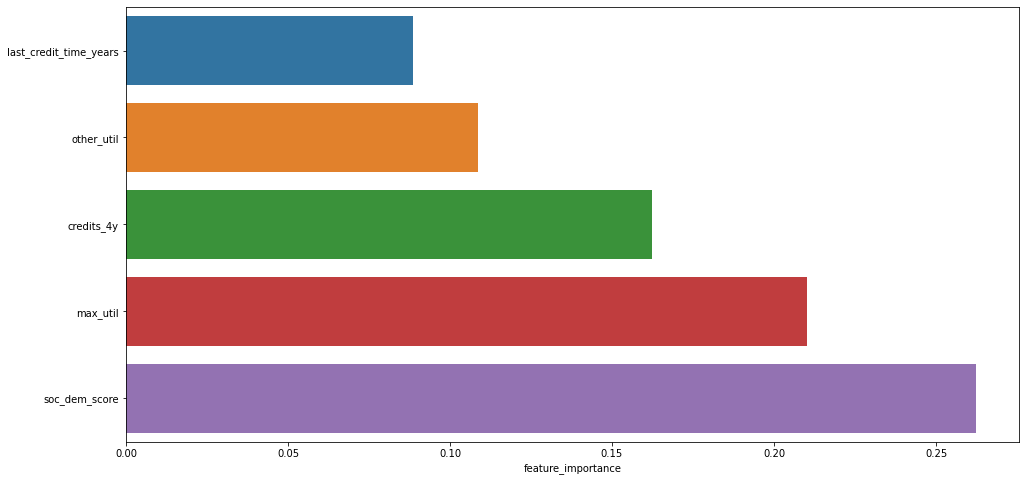

In [ ]:
coef = pd.DataFrame(pipe.get_params()['model'].coef_[0],index=new_filtered_features, columns=['feature_importance']).sort_values(by=['feature_importance'])
plot = sns.barplot(y=coef.index, x=coef['feature_importance'])
plot.figure.set_size_inches(16, 8)

Можно констатировать, что мы отобрали признаки, которые также были в топ-6 для бустинга по gain. Мне кажется, это связано с тем, что мы изначально воспользовались отбором по AUC-ROC, который относится к классу фильрующих методов, то есть мы отобрали фичи, которые хороши независимо от модели, поэтому самые сильные признаки для бустинга и логрега во многом совпадают.

## ROC-AUC логистической регрессии на тесте

In [ ]:
pred_test = pipe.predict_proba(df[new_filtered_features][df['sample_part'] == 'test'])[:, 1]
print(f"ROC-AUC на тесте логистической регрессии при отобранных признаках = {format(roc_auc_score(df['d4p12'][df['sample_part'] == 'test'], pred_test), '.3f')}")

ROC-AUC на тесте логистической регрессии при отобранных признаках = 0.607


Для того, чтобы понять, переобучилась модель или нет, мне кажется, разумно посмотреть на качество на обучающей выборке.

In [ ]:
pred_train = pipe.predict_proba(df[new_filtered_features][df['sample_part'] == 'train'])[:, 1]
print(f"ROC-AUC на трейне логистической регрессии при отобранных признаках = {format(roc_auc_score(df['d4p12'][df['sample_part'] == 'train'], pred_train), '.3f')}")

ROC-AUC на трейне логистической регрессии при отобранных признаках = 0.646


Как видим, значения метрик различаются некритично, значит явных признаков переобучения нет. Также имеет смысл посмотреть на дисперсию модели, так как известно, что высокий показатель этой величины свидетельствует о переобученности.

In [ ]:
X_train_new = df[new_filtered_features][df['sample_part'] == 'train']
y_train_new = df['d4p12'][df['sample_part'] == 'train']
X_test_new = df[new_filtered_features][df['sample_part'] == 'test']
y_test_new = df['d4p12'][df['sample_part'] == 'test']

avg_expected_loss, bias, variance = bias_variance_decomp.bias_variance_decomp(pipe, X_train_new.values, y_train_new.values, X_test_new.values, y_test_new.values, loss='0-1_loss', num_rounds=100)

print("Смещение модели : ", format(bias, '.7f'))
print("Дисперсия модели : ", format(variance, '.7f'))

Смещение модели :  0.0494874
Дисперсия модели :  0.0000077


Дисперсия не существенна.